In [4]:
# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
import numpy as np
import matplotlib.pyplot as plt

class BernouliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """
    def __init__(self, K):
        self.K = K
        self.probs = np.random.uniform(size = K)#* 随机生成K个0～1的数,作为拉动每根拉杆的获奖概率
        self.best_idx = self.probs.argmax()#* 获奖概率最大的拉杆
        self.best_prob =  self.probs[self.best_idx]#* 最大的获奖概率
    
    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未获奖）：
        if np.random.rand() < self.probs[k]: #*
            return 1
        else:
            return 0



np.random.seed(1)#* 设定随机种子,使实验具有可重复性
K = 10
bandit_10_arm = BernouliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" % (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


In [1]:
class Solver:
    """ 多臂老虎机算法基本框架 """
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)#* 每根拉杆的尝试次数
        self.regret = 0.#* 当前步的累积懊悔
        self.actions = []# 维护一个列表,记录每一步的动作
        self.regrets = []# 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, k):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        # 运行一定次数,num_steps为总运行次数
        for i in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1 #*
            self.update_regret(k)
            self.actions.append(k)

In [2]:
class EpsilonGreedy(Solver):
    """ epsilon贪婪算法,继承Solver类 """
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super().__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.array([init_prob] * self.bandit.K)#初始化拉动所有拉杆的期望奖励估值
        # self.estimates = np.zeros(self.bandit.K) # 初始化期望奖励估值为0，会变成一条直线

    def run_one_step(self):
        if np.random.random() < self.epsilon:#* 随机选择一根拉杆
            k = np.random.randint(0, self.bandit.K) #*       
        else:# 选择期望奖励估值最大的拉杆
            k = self.estimates.argmax()
        r = self.bandit.step(k)# 得到本次动作的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])#*更新期望估计
        return k# 返回选择

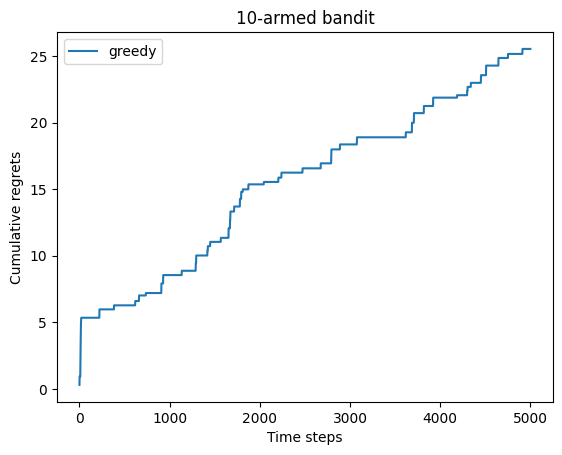

In [5]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for i, solver in enumerate(solvers):# 绘制每一个solver的图像
        time_list = range(len(solver.regrets)) #*
        plt.plot(time_list, solver.regrets, label = solver_names[i]) #*
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

np.random.seed(1)# 选择特定种子
greedy = EpsilonGreedy(bandit_10_arm, epsilon=0.01)# 实例化
greedy.run(5000)# 运行5000次
plot_results([greedy], ["greedy"])# 绘图

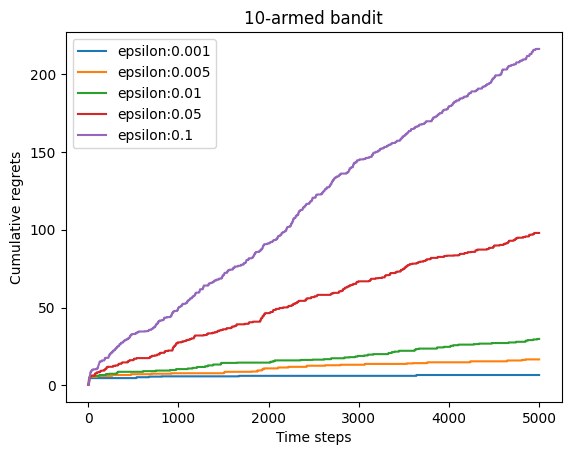

In [6]:
np.random.seed(0)# 选择特定种子
epsilons = [0.001, 0.005, 0.01, 0.05, 0.1]# 选择不同的探索值
epsilon_greedy_solver_list = [EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons]# 生成不同探索值的solver
epsilon_greedy_solver_names = ["epsilon:{}".format(e) for e in epsilons]# 生成不同探索值的solver的名字
for solver in epsilon_greedy_solver_list:
    solver.run(5000)# 运行5000幕解决

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)# 画图

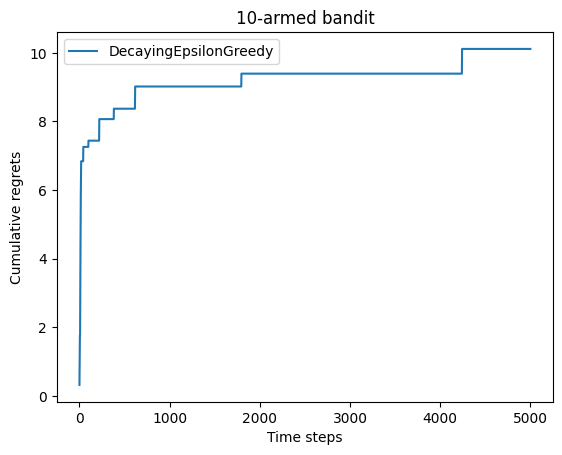

In [14]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super().__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)#*初始化期望
        self.total_count = 0#总共的尝试次数

    def run_one_step(self):
        self.total_count += 1
        if np.random.rand() < 1 / self.total_count:
            k = np.random.randint(0, self.bandit.K) #* 随机选择用randint,uniform返回的是浮点数
        else:
            k = self.estimates.argmax()# epsilon值随时间衰减
        r = self.bandit.step(k)# 获取奖励
        self.estimates[k] += 1./(self.counts[k] + 1) * (r - self.estimates[k])#* 更新期望,注意这个地方的计时不是总计数而是对应操作的计数
        return k# 返回动作

np.random.seed(1)# 选择随机种子1
solver = DecayingEpsilonGreedy(bandit_10_arm)#
solver.run(5000)#* 运行solver!
plot_results([solver],["DecayingEpsilonGreedy"])#

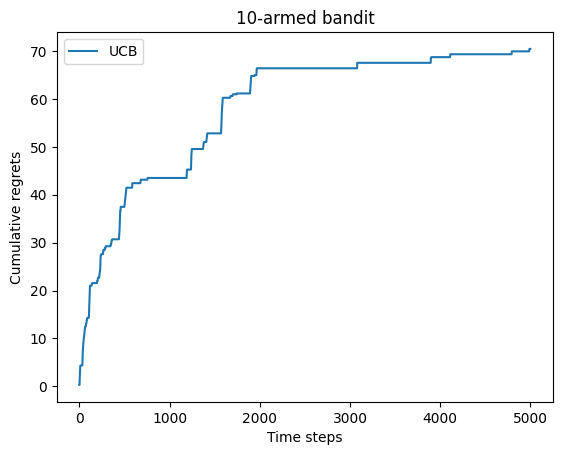

In [20]:
class UCB(Solver):
    """ UCB算法,继承Solver类 """
    def __init__(self, bandit, coef = 1, init_prob=1.0):
        super().__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1#
        ubc = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2*(self.counts + 1))) #* 计算上置信界
        k = ubc.argmax()# 选出上置信界最大的拉杆
        r = self.bandit.step(k)# 得到本次动作的奖励
        self.estimates[k] += 1/(self.counts[k] + 1)*(r - self.estimates[k])#* 更新期望奖励估值
        return k# 返回拉杆的编号

np.random.seed(1)# 
solver = UCB(bandit_10_arm)#
solver.run(5000)#
plot_results([solver],["UCB"])#

汤普森采样算法的累积懊悔为： 57.19161964443925


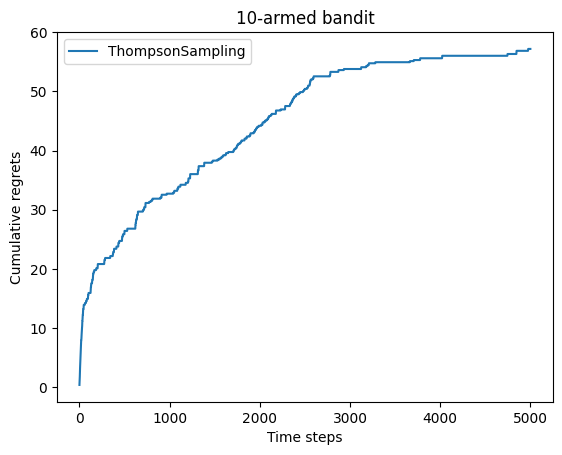

In [21]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k

np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])